# Road Signs Deep Learning classification 

---

![banner](banner.jpg)

---

## Content Table
- [1. Environment Preparation](#0.-Environment-Preparation)
- [2. Data Preprocessing](#2.-Data-Preprocessing)
  - [A. Data Loading](#A.-Data-Loading)
  - [B. Data Augmentation](#B.-Data-Augmentation)
- [3. Model Development](#3.-Model-Development)
- [4. Model Evaluation](#4.-Model-Evaluation)
- [5. Results Interpretation](#5.-Results-Interpretation)
  - [A. Misclassification](#A.-Misclassification)

### Project Overview
This project aims to classify road signs using a Convolutional Neural Network (CNN), important for autonomous driving systems. The GTSRB dataset is used, with data augmentation and model optimization techniques applied to improve performance.

### Objectives
- Classify road signs using CNNs.
- Preprocess and augment the GTSRB dataset.
- Design, train, and evaluate the CNN model.
- Optimize performance with techniques like regularization and transfer learning.
- Interpret the model predictions and evaluation results

### Dataset
The **GTSRB dataset** contains 50,000+ images of road signs. It will be split into training, validation, and test sets with data augmentation to increase robustness & generalization.

### Dependencies
- **Python**, **TensorFlow/Keras**, **Scikit-learn**, **OpenCV**, **Numpy**, **Pandas**, **Matplotlib**, **Seaborn**

---

## 1. Environment Preparation

In [1]:
import tensorflow as tf

# List all Gpus
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print(f"GPUs detected: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPU detected.")

No GPU detected.


In [2]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import randint
import matplotlib.pyplot as plt
import tensorflow.keras as keras

random_seed = 42 # Set random seed for reproducibility

In [3]:
train_data_path = "Data/archive/" # Path to the training data
image_size = (64, 64) # Target image size for the model
model_export_path = "Model/traffic_sign_classifier.keras" # Path to save the model
model_path = "Model/traffic_sign_classifier.keras" # Path to load the model

---

## 2. Data Preprocessing

### A. Data Loading

In [4]:
def load_data(meta_data, data_path, image_size, is_test=False):
    """
    Loads and preprocesses image data for training or testing.

    Parameters:
    meta_data (pd.DataFrame): A DataFrame containing metadata about the images, including file paths and class IDs.
    data_path (str): The base directory path where the image files are located.
    image_size (tuple): The target size for resizing the images (width, height).
    is_test (bool): A flag indicating whether the data is for testing. If True, the labels are not one-hot encoded.

    Returns:
    tuple: A tuple containing:
        - X (np.ndarray): An array of preprocessed images.
        - Y (np.ndarray): An array of labels, either one-hot encoded or as class IDs depending on the is_test flag.
    """
    # Encode labels as one-hot vectors if not in test mode, otherwise use class IDs directly
    Y = (
        keras.utils.to_categorical(meta_data["ClassId"])
        if not is_test
        else meta_data["ClassId"]
    )
    
    # Load and preprocess images
    X = np.array(
        [
            np.array(
                # Read image, convert from BGR to RGB, resize to target size
                cv2.resize(cv2.imread(data_path + path)[..., ::-1], image_size),
                dtype=np.float64,
            )
            for path in tqdm(meta_data.Path)  # Iterate over all image paths with a progress bar
        ]
    )
    
    # Return preprocessed images and labels
    return X, Y

In [5]:
train_meta_data = pd.read_csv("Data/archive/Train.csv")
train_meta_data = train_meta_data[["ClassId", "Path"]]
print("Loading training data...")
X, Y = load_data(train_meta_data, train_data_path, image_size)
print(f"Loaded {len(X)} training samples.")

Loading training data...


100%|██████████| 39209/39209 [00:32<00:00, 1219.63it/s]


Loaded 39209 training samples.


In [6]:
X.shape, Y.shape

((39209, 64, 64, 3), (39209, 43))

In [7]:
train_meta_data.ClassId.unique()

array([20,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=int64)

In [8]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }


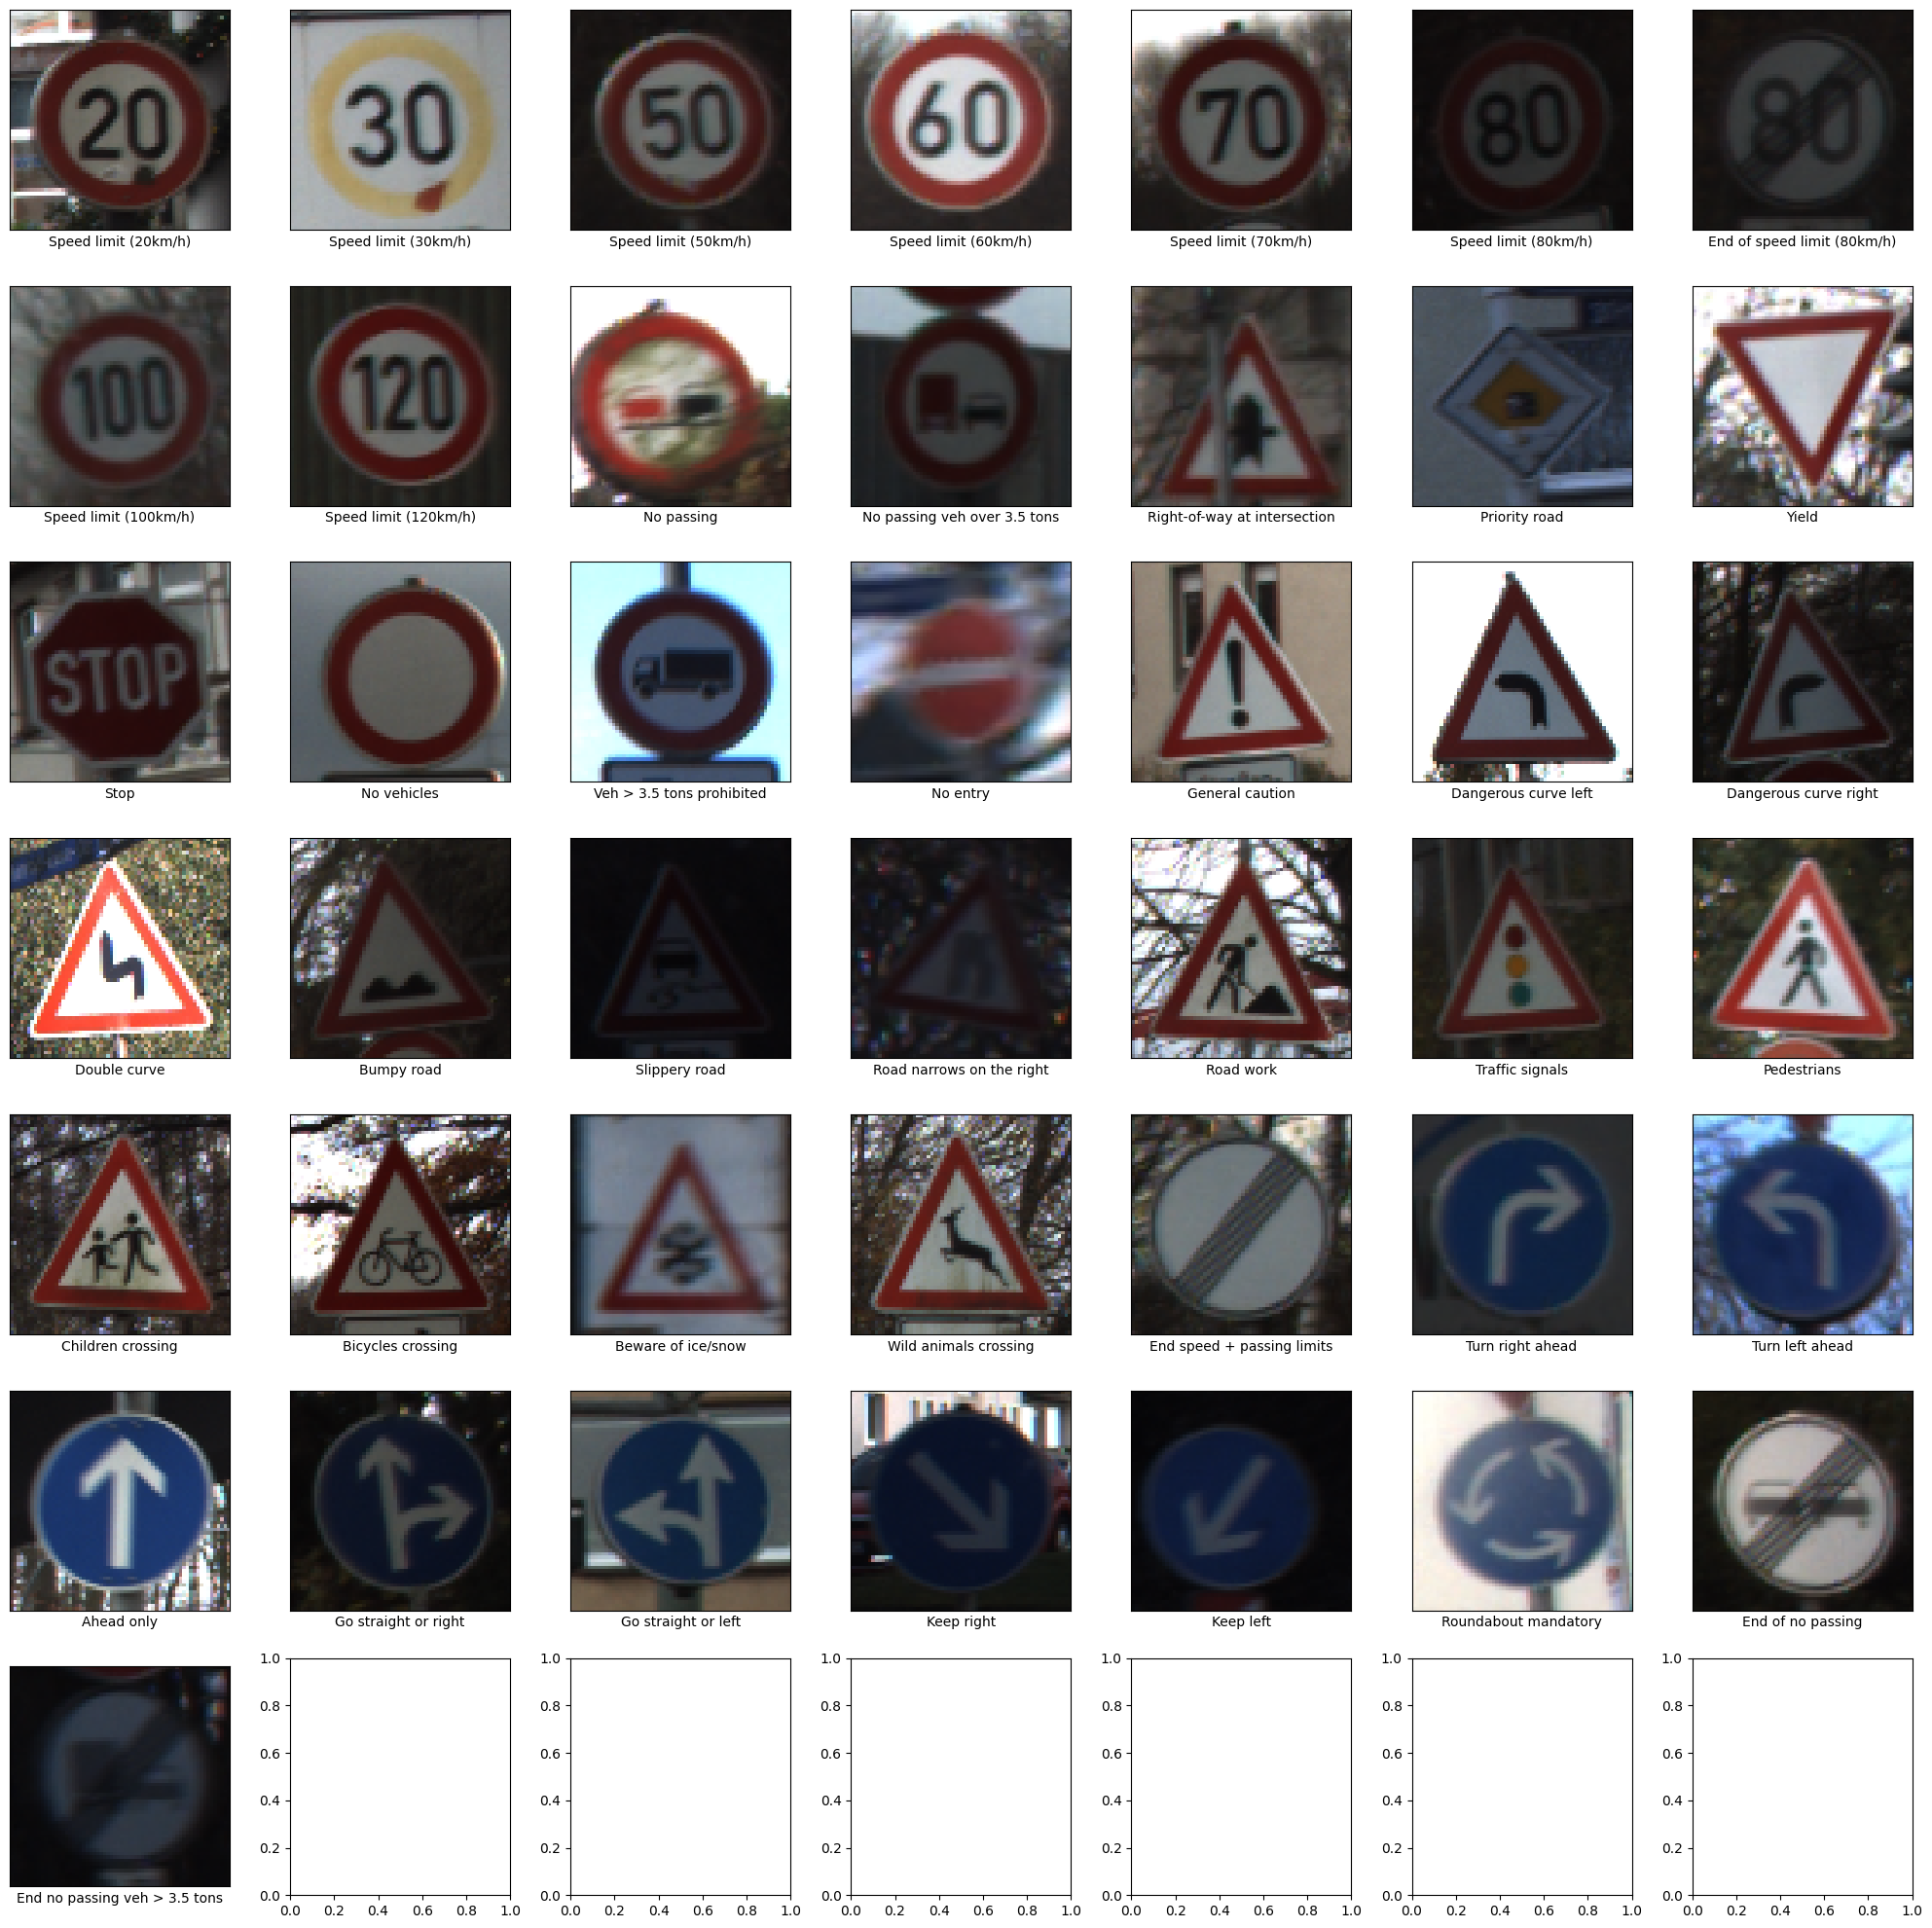

In [9]:
def plot_one_image_per_class(meta_data, X, classes):
    unique_classes = sorted(meta_data.ClassId.unique())  # Sort the unique class IDs in ascending order
    fig, axes = plt.subplots(7, 7, figsize=(20, 20))  # Create a 7x7 grid to display 43 images
    
    # Initialize index for iterating through the grid
    ax_idx = 0
    for class_id in unique_classes:
        # Find the index of the last occurrence of each `ClassId`
        index = meta_data[meta_data.ClassId == class_id].index[-1]
        
        # Display the corresponding image in the grid
        ax = axes[ax_idx // 7, ax_idx % 7] # Locate the subplot position in the 7x7 grid
        ax.imshow(X[index] / 255) # Show the image (normalized to [0, 1] range)
        ax.set_xlabel(classes[class_id])  # Set the class name as the label below the image
        ax.set_xticks([])  # Remove x-axis ticks for better visibility
        ax.set_yticks([])  # Remove y-axis ticks for better visibility
        
        # Move to the next cell in the grid
        ax_idx += 1
    
    plt.tight_layout() # Adjust the layout to prevent overlapping of subplots
    plt.show() # Display the grid of images

# Call the function
plot_one_image_per_class(train_meta_data, X, classes)


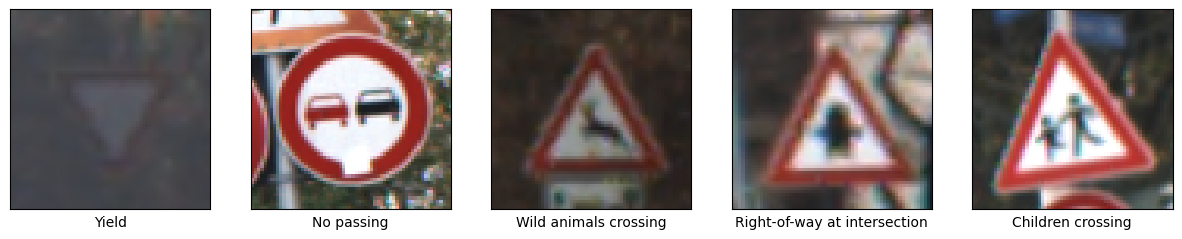

In [10]:
def plot_random_samples(meta_data, X, classes):
    """
    Plots random samples of images with their corresponding class IDs.

    Parameters:
    meta_data (pd.DataFrame): A DataFrame containing metadata about the images, including class IDs.
    X (np.ndarray): An array of preprocessed images.

    Returns:
    None
    """
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        n = randint(0, len(X))  # Sélectionner un index aléatoire
        class_id = meta_data.ClassId.iloc[n]  # Obtenir l'ID de classe correspondant
        class_name = classes[class_id]  # Mapper l'ID de classe au nom de classe
        
        # Afficher l'image
        axes[i].imshow(X[n] / 255)
        
        # Ajouter le nom de classe comme label sous l'image
        axes[i].set_xlabel(class_name)
        
        # Enlever les ticks
        axes[i].set_xticks(())
        axes[i].set_yticks(())
    
    plt.show()

# Appeler la fonction en passant le dictionnaire `classes`
plot_random_samples(train_meta_data, X, classes)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=random_seed,
    # stratify=Y,
)

In [12]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((31367, 64, 64, 3), (7842, 64, 64, 3), (31367, 43), (7842, 43))

### B. Data Augmentation

In [13]:
# Create an ImageDataGenerator for data augmentation during training
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,  # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,  # Randomly shift images vertically by 10% of the height
    zoom_range=0.1,  
    rotation_range=10,  
    brightness_range=[0.9, 1.1],  
)

# Create an iterator for the training data with a batch size of 64
it_train = train_datagen.flow(X_train, Y_train, batch_size=64)

it_val = train_datagen.flow(X_val, Y_val, batch_size=64)

---

## 3. Model Development

In [14]:
from keras.models import Sequential
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Rescaling,
    Input,
)

# Create the model structure
model = Sequential(
    [ 
        Input(shape=(64, 64, 3)),

        Rescaling(1.0 / 255.0),

        Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation="relu"),
        Dropout(0.5),

        Dense(units=43, activation="softmax"),
    ]
)


print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,779 (940.54 KB)

 Trainable params: 240,299 (938.67 KB)

 Non-trainable params: 480 (1.88 KB)

None


In [15]:
# Compile the model

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

earlystop = keras.callbacks.EarlyStopping(patience=6) # Stop training early if the validation loss stops improving
reducelr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00005) # Reduces the learning rate when the validation loss stops improving
modelcheckpoint = keras.callbacks.ModelCheckpoint('Best_Model.keras', verbose=1, save_best_only=True, monitor='val_accuracy', mode='max') #Saves the model when there is an improvement in validation accuracy

history = model.fit(it_train, validation_data=it_val, epochs=30, callbacks=[earlystop, reducelr, modelcheckpoint])

Epoch 1/30


c:\Users\jcrig\Documents\FORMATION_SORBONNE\Deep_Learning_Krasniki\Road-Signs-Deep-Learning-Classification\dl-venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4268 - loss: 2.1559
Epoch 1: val_accuracy improved from -inf to 0.77901, saving model to Best_Model.keras
491/491 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.4272 - loss: 2.1541 - val_accuracy: 0.7790 - val_loss: 0.7027 - learning_rate: 0.0010
Epoch 2/30
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8941 - loss: 0.3444
Epoch 2: val_accuracy improved from 0.77901 to 0.96072, saving model to Best_Model.keras
491/491 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.8942 - loss: 0.3442 - val_accuracy: 0.9607 - val_loss: 0.1408 - learning_rate: 0.0010
Epoch 3/30
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9483 - loss: 0.1656
Epoch 3: val_accuracy improved from 0.96072 to 0.98215, saving model to Best_Model.keras
491/491 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.9483 - loss: 0.1655 - val_accuracy: 0.9821 - val_loss: 0.0624 - learning_rate: 0.0010
Epoch 4/30
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - ac

Max val_acc 0.9992349147796631


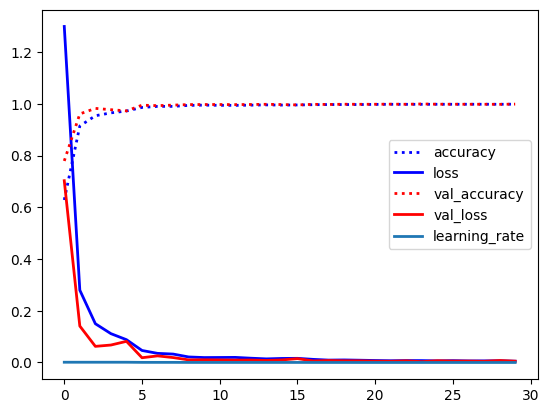

In [17]:
import pandas as pd
import numpy as np

pd.DataFrame(history.history).plot(lw=2, style=["b:", "b-", "r:", "r-"]) # PLot the training and validation metrics
print("Max val_acc", np.max(history.history["val_accuracy"]))

---

## 4. Model Evaluation

In [56]:
model_path = 'Best_Model.keras'
model = keras.models.load_model(model_path) # Load the model

In [57]:
test_data_path = "Data/archive/"
test_meta_data = pd.read_csv("Data/archive/Test.csv")
test_meta_data = test_meta_data[["ClassId", "Path"]]
print("Loading test data...")
X_test, Y_test = load_data(test_meta_data, test_data_path, image_size, is_test=True) # Load the test data
print(f"Loaded {len(X_test)} test samples.")

Loading test data...


100%|██████████| 12630/12630 [02:08<00:00, 98.36it/s] 


Loaded 12630 test samples.


In [21]:
X_test.shape, Y_test.shape

((12630, 64, 64, 3), (12630,))

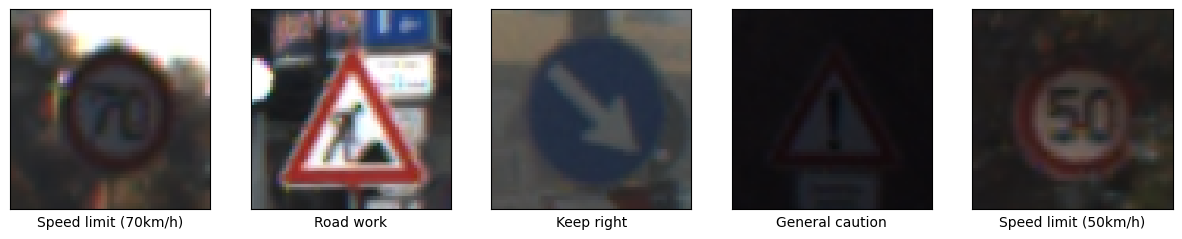

In [22]:
plot_random_samples(test_meta_data, X_test, classes)

In [53]:
pred = model.predict(X_test, verbose=1) # Make predictions on the test data

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [54]:
pred.shape

(12630, 43)

In [58]:
Y_pred = np.argmax(pred, axis=1)
Y_pred[:5]

array([16,  1, 38, 33, 11], dtype=int64)

In [26]:
Y_test

0        16
1         1
2        38
3        33
4        11
         ..
12625    12
12626    33
12627     6
12628     7
12629    10
Name: ClassId, Length: 12630, dtype: int64

In [59]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
)

print(classification_report(Y_test, Y_pred))
print("Accuracy: ", accuracy_score(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.99      1.00      1.00       720
           2       0.99      1.00      0.99       750
           3       1.00      0.96      0.98       450
           4       1.00      0.99      0.99       660
           5       0.96      0.99      0.98       630
           6       0.99      0.95      0.97       150
           7       0.99      1.00      0.99       450
           8       0.99      0.97      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.98      0.96      0.97       420
          12       1.00      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       0.99      1.00      0.99       270
          15       0.98      1.00      0.99       210
          16       0.99      1.00      1.00       150
          17       1.00    

In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, Y_pred) # Compute the confusion matrix

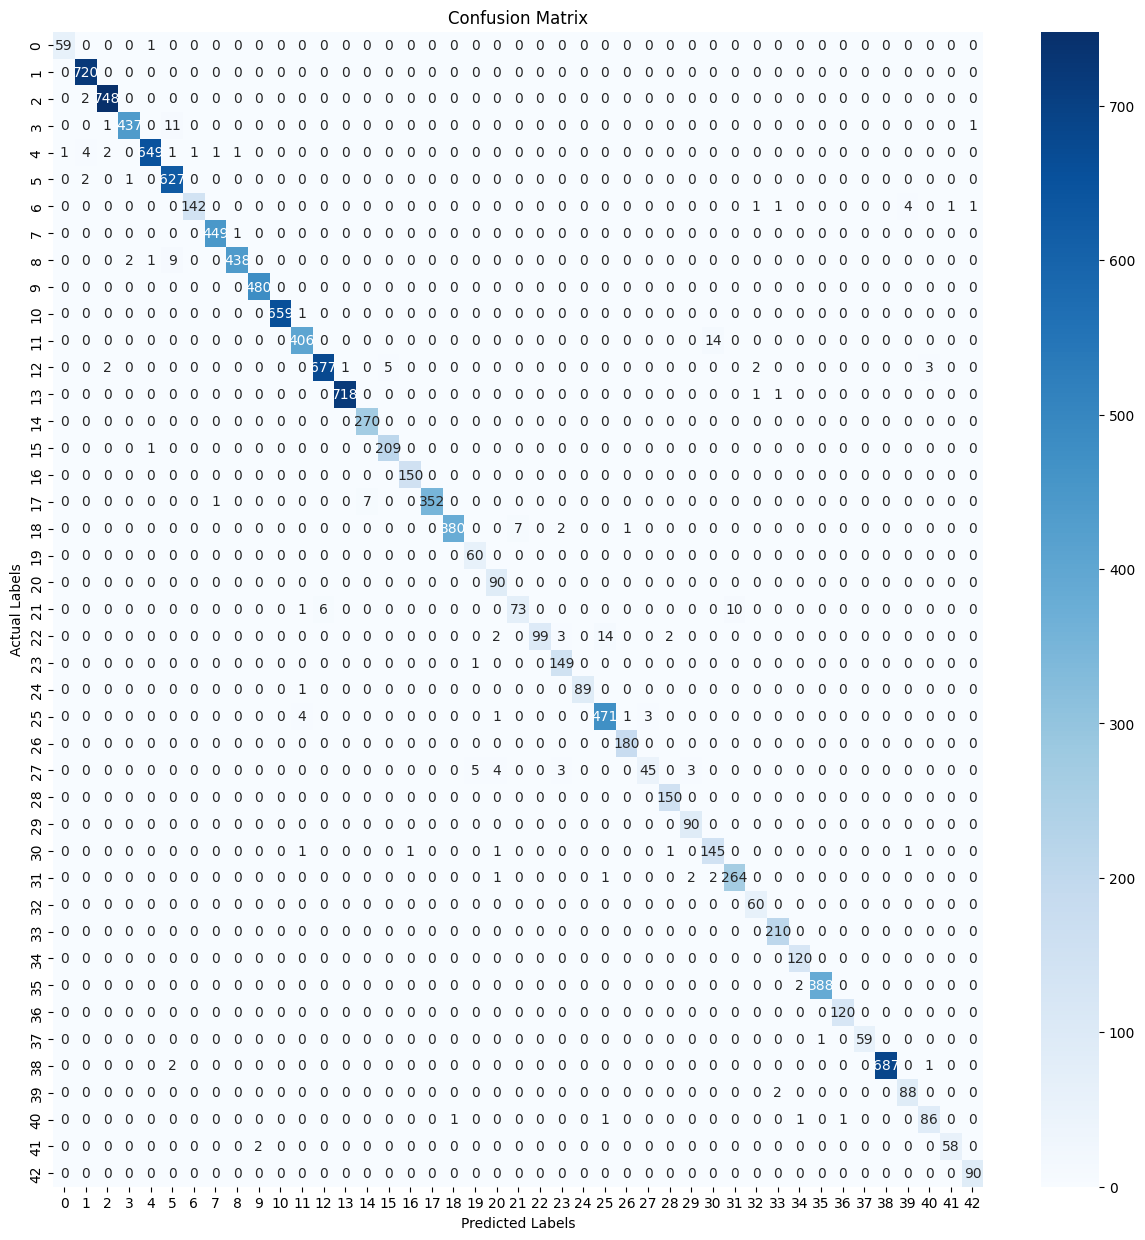

In [29]:
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

---

## 5. Interpretation

### A. Misclassification

In [30]:
Y_test.shape,Y_pred.shape # Verify the shapes of the true and predicted labels

((12630,), (12630,))

In [31]:
misclassified_samples = np.nonzero(Y_test != Y_pred)[0] # Find the indices of misclassified samples
misclassified_samples.shape

(189,)

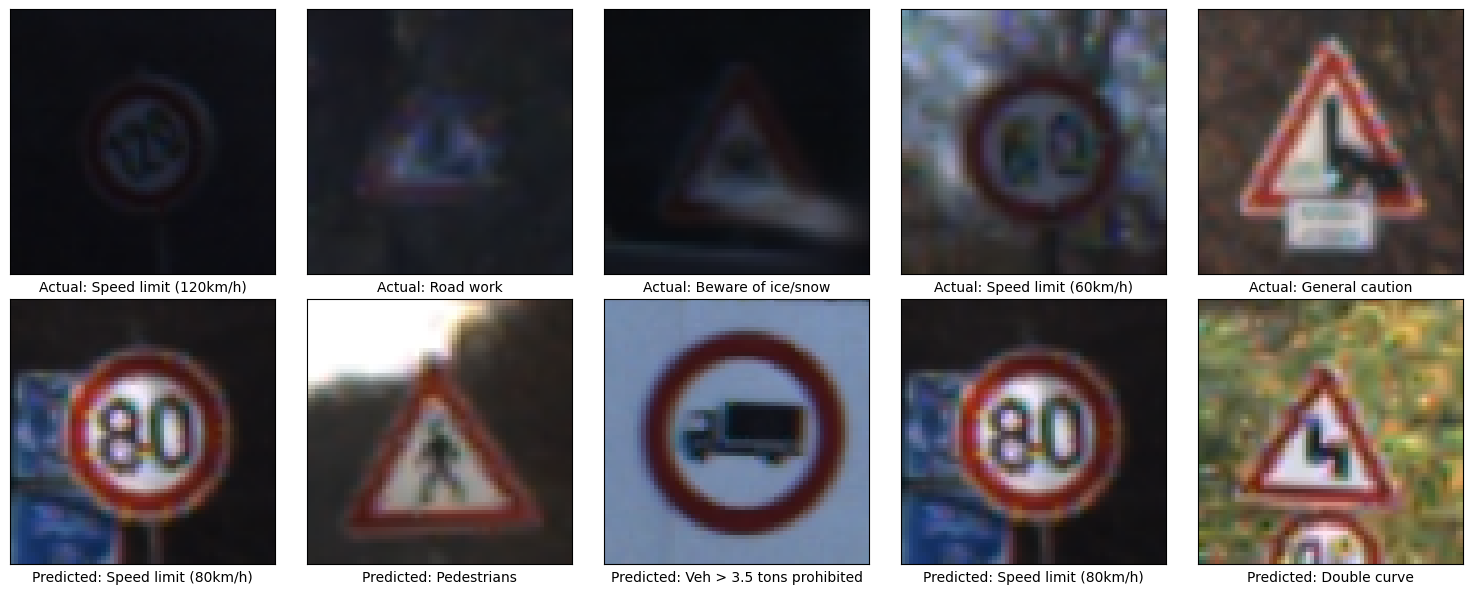

In [35]:
nb_misclassifications = 5  # Number of misclassified images to display
fig, axes = plt.subplots(2, nb_misclassifications, figsize=(15, 6))  # 2 rows: one for actual image, one for predicted

for nr, i in enumerate(misclassified_samples[:nb_misclassifications]):
    # Display the misclassified image (actual image)
    axes[0, nr].imshow(X_test[i] / 255.0)
    axes[0, nr].set_xlabel("Actual: %s" % (classes[Y_test[i]]))  # Display class names
    axes[0, nr].set_xticks(()), axes[0, nr].set_yticks(())

    # Find an example of the predicted class to compare
    predicted_class_index = np.where(Y_test == Y_pred[i])[0][0]  # Find an index where the predicted class appears
    axes[1, nr].imshow(X_test[predicted_class_index] / 255.0)
    axes[1, nr].set_xlabel("Predicted: %s" % (classes[Y_pred[i]]))  # Display class name for predicted class
    axes[1, nr].set_xticks(()), axes[1, nr].set_yticks(())

plt.tight_layout()
plt.show()


### B. Prediction Visualization - GradCam

In [50]:
def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)  # Load image
    img = cv2.resize(img, (64, 64))  # Resize to your input size
    img = img.astype('float32') / 255.0  # Scale to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def get_grad_cam(model, img_array, layer_name, class_index):
    # Create a model that maps the input image to the output of the last convolutional layer
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # Forward pass
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[0][class_index]  # Get the score for the class

    # Compute gradients of the class score with respect to the output feature map
    grads = tape.gradient(loss, conv_outputs)[0]

    # Pool the gradients across the spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Multiply the feature map by the pooled gradients
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]  # Weighted sum of feature maps

    # Apply ReLU to the heatmap
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap between 0 and 1
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

def superimpose_heatmap(heatmap, img_path, alpha=0.4):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))  # Resize to match the heatmap size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Resize heatmap to match original image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)  # Scale heatmap to [0, 255]
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply a colormap

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    
    return superimposed_img

# Example usage
img_path = 'Data/archive/Test/00001.png'  # Replace with your image path
img_array = load_and_preprocess_image(img_path)

# Assuming 'model' is your trained model and 'layer_name' is the last convolutional layer
layer_name = 'conv2d_3'  # Replace with the actual name of the last conv layer

# Get class index of the prediction
predictions = model.predict(X_test)
class_index = np.argmax(predictions[0])  # Get the index of the predicted class

# Generate the Grad-CAM heatmap
heatmap = get_grad_cam(model, img_array, layer_name, class_index)

# Superimpose the heatmap on the original image
superimposed_img = superimpose_heatmap(heatmap, img_path)

# Display the result
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


ValueError: The layer sequential has never been called and thus has no defined input.